In [ ]:
import numpy as np
import tensorflow
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import zipfile


In [ ]:
os.environ['KAGGLE_CONFIG_DIR']='/content'
!kaggle datasets download -d ahemateja19bec1025/traffic-sign-dataset-classification

traffic-sign-dataset-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
zip_file_path = "/content/traffic-sign-dataset-classification.zip"

extracted_folder_path = "/content/"
# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents of the zip file to the specified directory
    zip_ref.extractall(extracted_folder_path)

In [ ]:
path = "/content/traffic_Data/DATA"
labelFile = '/content/labels.csv'

In [ ]:
batch_size_val=32
epochs_val=15
imageDimesions = (32,32,3)
testRatio = 0.2
validationRatio = 0.2
target_size = (224, 224)
count = 0
images = []
classNo = []

In [ ]:
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses=len(myList)
print("Importing Classes.....")

Total Classes Detected: 58
Importing Classes.....


In [ ]:
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:

        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        curImg = cv2.resize(curImg, target_size)
        images.append(curImg)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57  


In [ ]:
images = np.array(images)
classNo = np.array(classNo)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

In [ ]:
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)

Data Shapes
Train(2668, 224, 224, 3) (2668,)
Validation(668, 224, 224, 3) (668,)
Test(834, 224, 224, 3) (834,)


In [ ]:
data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))

data shape  (58, 2) <class 'pandas.core.frame.DataFrame'>


In [ ]:
num_of_samples = []
cols = 5
num_classes = noOfClasses

In [ ]:
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

In [ ]:
X_train=np.array(list(map(preprocessing,X_train)))
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))

In [ ]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

In [ ]:
dataGen= ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10)
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=20)
X_batch,y_batch = next(batches)

In [ ]:
y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)

In [ ]:
def myModel():
    model= Sequential()
    model.add((Conv2D(60,(5,5),input_shape=(224,224,1),activation='relu')))
    model.add((Conv2D(60, (5,5), activation='relu')))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add((Conv2D(30, (3,3),activation='relu')))
    model.add((Conv2D(30, (3,3), activation='relu')))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses,activation='softmax'))
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [ ]:
model = myModel()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 60)      1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 216, 216, 60)      90060     
                                                                 
 max_pooling2d (MaxPooling2  (None, 108, 108, 60)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 106, 106, 30)      16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 104, 104, 30)      8130      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 52, 52, 30)        0         
 g2D)                                                   

In [ ]:
history=model.fit(dataGen.flow(X_train,y_train,batch_size=32),steps_per_epoch=len(X_train)//32,epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)

Epoch 1/15
83/83 [==============================] - 48s 412ms/step - loss: 3.3406 - accuracy: 0.1825 - val_loss: 2.6116 - val_accuracy: 0.2859
Epoch 2/15
83/83 [==============================] - 20s 243ms/step - loss: 2.6524 - accuracy: 0.3126 - val_loss: 1.9905 - val_accuracy: 0.4626
Epoch 3/15
83/83 [==============================] - 20s 240ms/step - loss: 2.1257 - accuracy: 0.4273 - val_loss: 1.4180 - val_accuracy: 0.6392
Epoch 4/15
83/83 [==============================] - 20s 239ms/step - loss: 1.7513 - accuracy: 0.5057 - val_loss: 1.1033 - val_accuracy: 0.7021
Epoch 5/15
83/83 [==============================] - 20s 240ms/step - loss: 1.4507 - accuracy: 0.5945 - val_loss: 0.8768 - val_accuracy: 0.7530
Epoch 6/15
83/83 [==============================] - 20s 245ms/step - loss: 1.3819 - accuracy: 0.6131 - val_loss: 0.7845 - val_accuracy: 0.8114
Epoch 7/15
83/83 [==============================] - 20s 244ms/step - loss: 1.2032 - accuracy: 0.6514 - val_loss: 0.6987 - val_accuracy: 0.8413

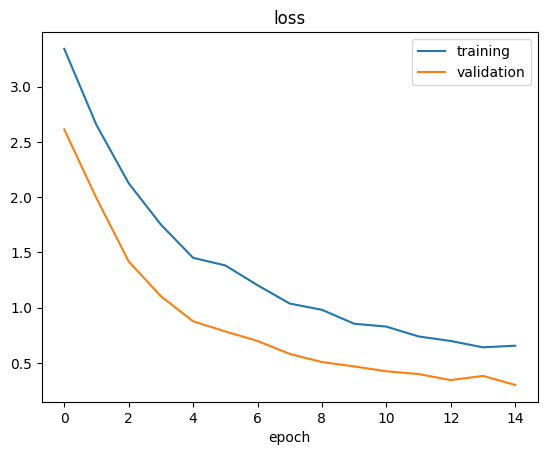

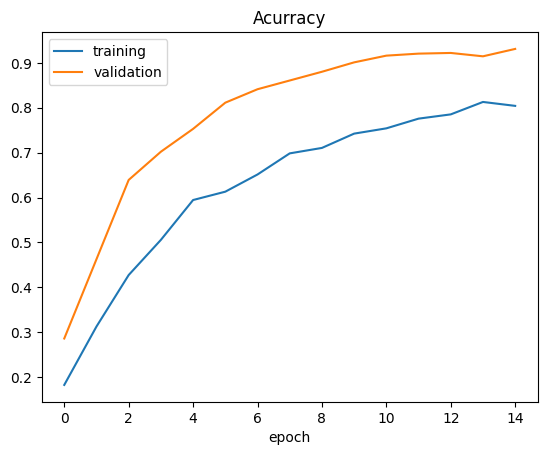

In [ ]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

Test Score: 0.301746666431427
Test Accuracy: 0.9268584847450256


In [ ]:
predictions = []

In [ ]:
folder_path = "/content/traffic_Data/TEST"

In [ ]:
for filename in os.listdir(folder_path):

    if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):

        image_path = os.path.join(folder_path, filename)
        test_img=cv2.imread(image_path)
        new_img=cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
        new_img=cv2.resize(new_img,(224,224))
        new_input=new_img.reshape((1,224,224,1))
        pred=model.predict(new_input)

        predictions.append(pred)

1/1 [==============================] - 0s 18ms/step
